# Step 1: Load Data

In [27]:
import pandas as pd

In [28]:
df = pd.read_csv('data_sarima.csv')

In [29]:
display(df.head()) 
display(df.tail())    

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


,Month,Perrin Freres monthly champagne sales millions ?64-?72
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0
105,NaN,NaN
106,Perrin Freres monthly champagne sales millions...,NaN


In [30]:
df.columns = ["Month", "sales"]
display(df.tail())

,Month,sales
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0
105,NaN,NaN
106,Perrin Freres monthly champagne sales millions...,NaN


In [31]:
df = df.dropna()
display(df.tail())

,Month,sales
100,1972-05,4618.0
101,1972-06,5312.0
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0


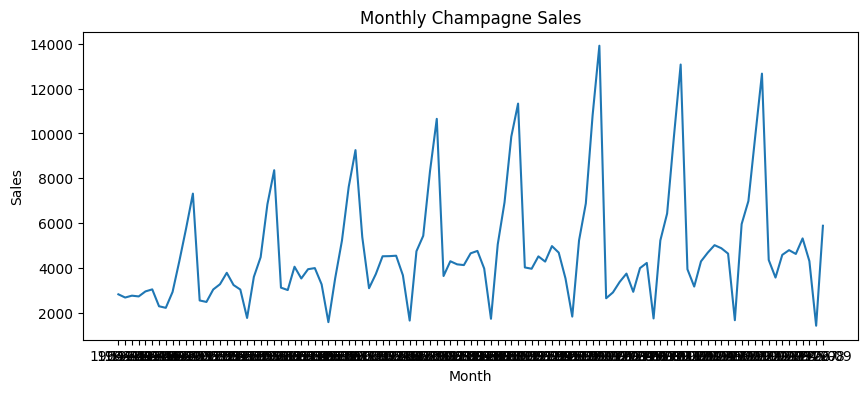

In [32]:
import matplotlib.pyplot as plt   

plt.figure(figsize=(10, 4))       
plt.plot(df["Month"], df["sales"]) 
plt.title("Monthly Champagne Sales")  
plt.xlabel("Month")                   
plt.ylabel("Sales")                   
plt.show()          

The series shows strong yearly seasonality, an upward trend, and non-stationarity

### **Step 2: Data Cleansing**
 *Ensure proper time index*

In [33]:
import pandas as pd

df["Month"] = pd.to_datetime(df["Month"])  # Convert to datetime
df = df.set_index("Month")                # Set date as time index

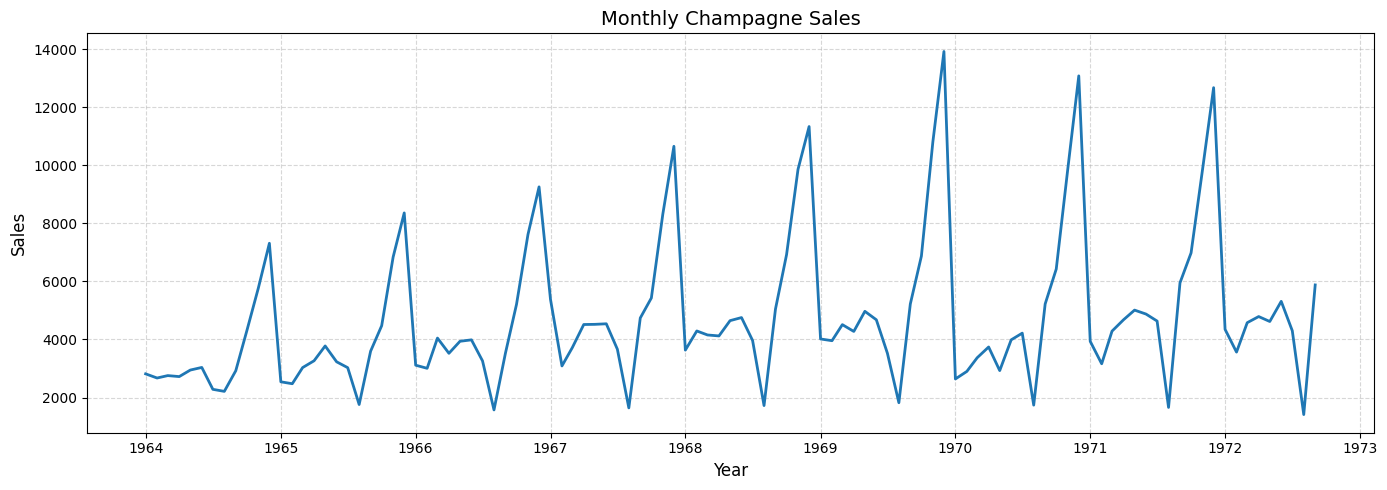

In [34]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(14, 5))                 # Wide, professional layout
plt.plot(df["sales"], linewidth=2)          # Thicker line for clarity

plt.title("Monthly Champagne Sales", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Sales", fontsize=12)

# Set x-axis ticks every 5 years
ax = plt.gca()                               # Get current axis
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.grid(True, linestyle="--", alpha=0.5)   # Light grid for readability
plt.tight_layout()                           # Clean spacing
plt.show()

**Visual inspection:** Variance increases with the level (heteroskedasticity)

If: Peaks grow larger over time and Seasonal swings get bigger as the series grows, then Then a log transform is recommended.

In [35]:
import numpy as np
df["l_sales"] = np.log(df["sales"]) # covert sales to log sales

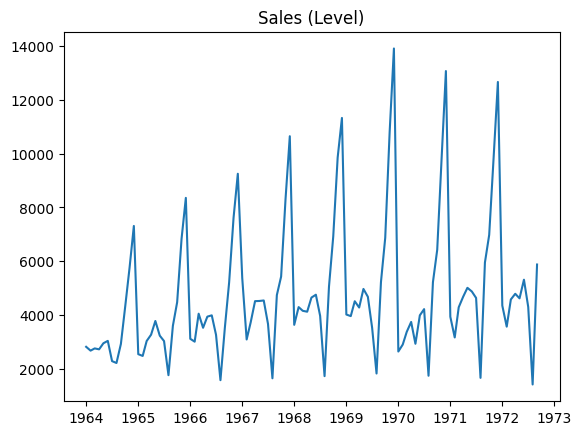

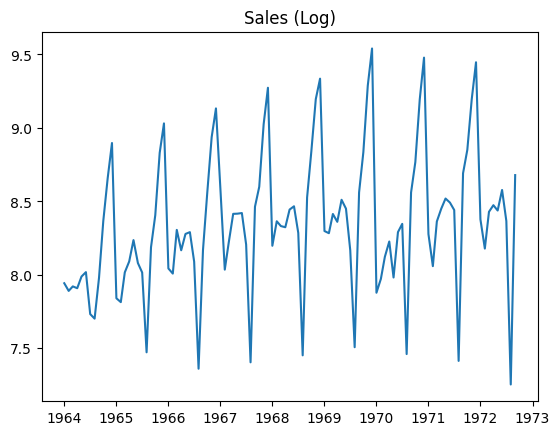

In [36]:
# Level series
plt.plot(df["sales"])
plt.title("Sales (Level)")
plt.show()

# Log-transformed series
plt.plot(np.log(df["sales"]))
plt.title("Sales (Log)")
plt.show()

**Note:** Log transformation is not mandatory in time-series forecasting, but it is recommended when variance increases with the level or seasonality is multiplicative, particularly for ARIMA/SARIMA models.

**Step 3: STOCHASTIC PROPERTIES & PRE-TESTING**

3.1 ACF of the original (level) series

<Figure size 1000x400 with 0 Axes>

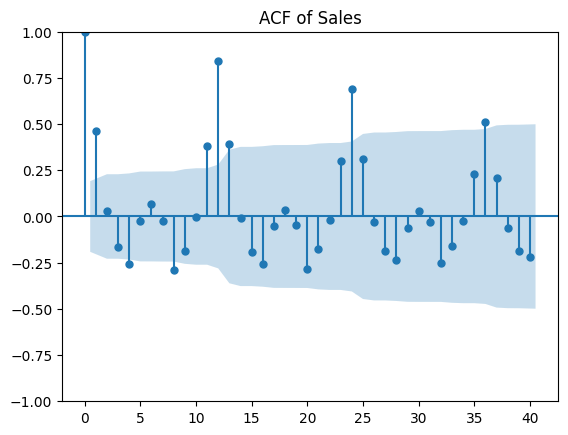

In [ ]:
import matplotlib.pyplot as plt
# Imports matplotlib to create plots

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Imports built-in functions to plot ACF and PACF easily

plt.figure(figsize=(10, 4))
# Creates a figure with a clean, wide size for readability

plot_acf(df["sales"], lags=40)
# Plots autocorrelation of the sales series up to 40 lags

plt.title("ACF of Sales")
# Adds a clear title to explain what the plot shows

plt.show()
# Displays the ACF plot

**Analyis:** The ACF of the level series displays strong persistence and a slow decay of autocorrelations, indicative of non-stationarity. Highly significant spikes at seasonal lags (12, 24, and 36) confirm pronounced annual seasonality and suggest the presence of a seasonal unit root. These features imply that both regular and seasonal differencing are necessary prior to ARIMA model identification.

**White NOise?**
Time plot: The series shows a clear upward trend and strong, regular seasonal fluctuations, whereas white noise would fluctuate randomly around a constant mean with no visible structure.

Autocorrelation (ACF): The ACF displays many statistically significant autocorrelations that decay slowly and strong spikes at seasonal lags (e.g., 12, 24), while white noise would show autocorrelations close to zero at all non-zero lags.


<Figure size 1000x400 with 0 Axes>

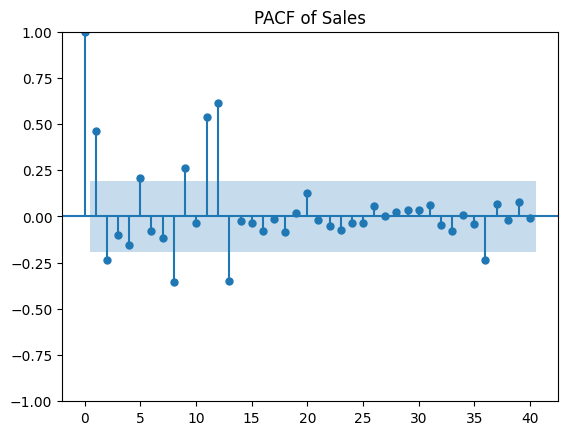

In [ ]:
plt.figure(figsize=(10, 4))
# Creates a new figure for the PACF plot

plot_pacf(df["sales"], lags=40)
# Plots partial autocorrelation up to 40 lags using a stable method

plt.title("PACF of Sales")
# Adds a descriptive title

plt.show()
# Displays the PACF plot


The PACF shows a strong spike at lag 1 and a pronounced seasonal spike around lag 12, with most higher-order lags insignificant, indicating high persistence and clear annual seasonality but confirming that the level series is non-stationary.

*Persistence means today’s sales still ‘remember’ what happened many months ago.*

3.2 Unit root test--ADF Test to check stationarity

In [ ]:
from statsmodels.tsa.stattools import adfuller

adf = adfuller(df["sales"])

print("ADF statistic:", adf[0])
print("p-value:", adf[1])

ADF statistic: -1.8335930563276215
p-value: 0.36391577166024586


The ADF test on the level series fails to reject the unit-root null, confirming non-stationarity.

**3.3 Make the series stationary by differencing**

In [ ]:
import numpy as np
# Numerical library (needed for log)

df["d_sales"] = df["sales"].diff()
# First difference to remove trend

df_diff = df.dropna()
# Remove NaN created by differencing

In [ ]:
df_diff

,sales,l_sales,d_sales
Month,,,
1964-02-01,2672.0,7.890583,-143.0
1964-03-01,2755.0,7.921173,83.0
1964-04-01,2721.0,7.908755,-34.0
1964-05-01,2946.0,7.988204,225.0
1964-06-01,3036.0,8.018296,90.0
...,...,...,...
1972-05-01,4618.0,8.437717,-170.0
1972-06-01,5312.0,8.577724,694.0
1972-07-01,4298.0,8.365905,-1014.0


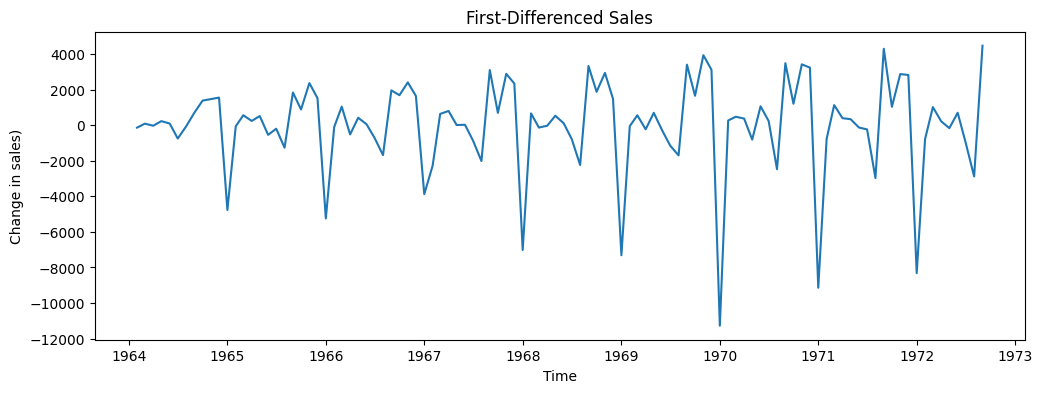

In [ ]:
import matplotlib.pyplot as plt
# Plotting library

plt.figure(figsize=(12, 4))
# Set clean figure size

plt.plot(df_diff["d_sales"])
# Plot differenced log series

plt.title("First-Differenced Sales")
# Describe what is plotted

plt.xlabel("Time")
# X-axis label

plt.ylabel("Change in sales)")
# Y-axis label

plt.show()
# Display the plot


The first-differenced log series fluctuates around zero with no visible trend but retains clear seasonal spikes, indicating that regular differencing has removed the trend while seasonal dependence remains and seasonal differencing is still required.

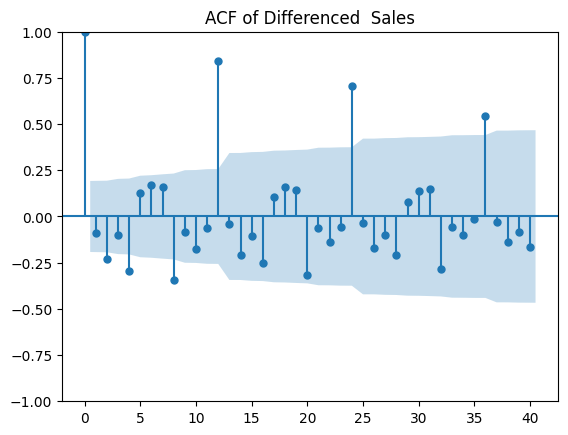

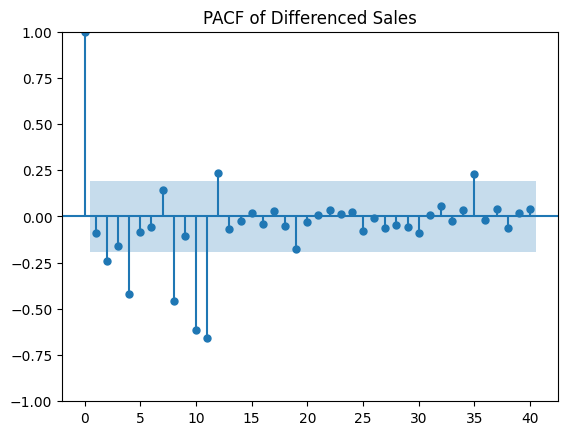

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df_diff["d_sales"], lags=40)
# Check remaining autocorrelation

plt.title("ACF of Differenced  Sales")
# Title for clarity

plt.show()


plot_pacf(df_diff["d_sales"], lags=40, method="ywm")
# Check partial autocorrelation

plt.title("PACF of Differenced Sales")
# Title for clarity

plt.show()

The ACF of the differenced series still shows strong, significant spikes at seasonal lags (12, 24, 36), indicating that seasonal dependence remains after regular differencing.
The PACF is largely insignificant beyond a few low and seasonal lags, suggesting that once seasonal differencing is applied, a low-order SARIMA model will be adequate.

In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_stat, p_value = adfuller(df_diff["d_sales"])[:2]
# Run ADF test

print("ADF statistic:", adf_stat)
print("p-value:", p_value)


ADF statistic: -7.189896448050999
p-value: 2.519620447387081e-10


This means the differenced series is stationary, confirming that the applied differencing has successfully removed the non-stationarity.

but the ACF still has strong spikes at lag 12, which means seasonal dependence remains.

*The series is trend-stationary after first differencing, but not seasonally stationary.*

**4. Auto Regressive Model**

In [ ]:
y = df_diff["d_sales"]
# Stationary series ready for AR modeling


4.1. Train–test (holding period) split

We hold out the last 12 months.

In [ ]:
train = y.iloc[:-12]
# Training data (all except last 12 months)

test = y.iloc[-12:]
# Holding (test) period: last 12 months


4.2. Find optimal AR lag using AIC and BIC

We try AR(p) models for p = 1 to 12.

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
import pandas as pd

results = []

for p in range(1, 13):
    model = AutoReg(train, lags=p, old_names=False).fit()
    # Fit AR(p) model

    results.append([p, model.aic, model.bic])
    # Store lag, AIC, and BIC

lag_table = pd.DataFrame(results, columns=["Lag (p)", "AIC", "BIC"])
lag_table


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

,Lag (p),AIC,BIC
0,1,1693.277804,1700.810383
1,2,1672.432108,1682.431346
2,3,1654.276895,1666.720076
3,4,1622.136418,1637.000439
4,5,1606.351552,1623.612909
5,6,1590.560946,1610.195724
6,7,1573.767521,1595.751382
7,8,1538.282734,1562.590902
8,9,1521.353989,1547.961236
9,10,1461.675411,1490.556042


How to choose p

Lowest AIC → better fit

Lowest BIC → more parsimonious

Prefer BIC

In [ ]:
p_opt = lag_table.loc[lag_table["BIC"].idxmin(), "Lag (p)"]
p_opt

np.int64(12)

2. Differencing ≠ seasonal differencing

You differenced only once:d_sales
t	​=salest	​−salest−1
	​


This removes trend, not seasonality.

So lag 12 still matters.


Why AR(12) is usually a red flag here

While statistically valid, AR(12):

Is not parsimonious

Masks seasonality rather than modeling it structurally

Produces unstable forecasts

Violates good Box–Jenkins practice for seasonal data

4.3. Fit the final AR model


In [ ]:
ar_model = AutoReg(train, lags=12).fit()
# Fit AR model with optimal lag

print(ar_model.summary())


                            AutoReg Model Results                             
Dep. Variable:                d_sales   No. Observations:                   92
Model:                    AutoReg(12)   Log Likelihood                -643.264
Method:               Conditional MLE   S.D. of innovations            751.347
Date:                Thu, 01 Jan 2026   AIC                           1314.529
Time:                        13:56:26   BIC                           1347.877
Sample:                    02-01-1965   HQIC                          1327.899
                         - 09-01-1971                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         273.7374     91.723      2.984      0.003      93.963     453.512
d_sales.L1     -0.7497      0.110     -6.831      0.000      -0.965      -0.535
d_sales.L2     -0.8333      0.111     -7.494    

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


4.4. Forecast the holding (test) period

In [ ]:
test_pred = ar_model.predict(
    start=test.index[0],
    end=test.index[-1],
    dynamic=False
)
# One-step-ahead predictions for test period


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


5. Visualization 1: Holding (test) period performance

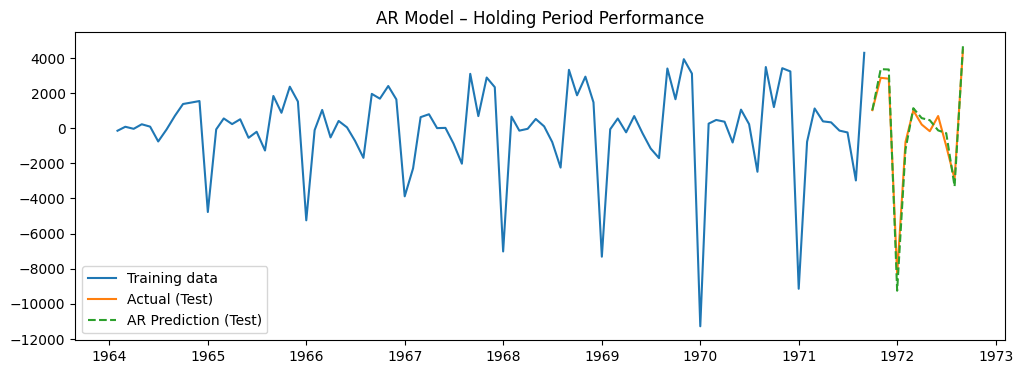

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(train.index, train, label="Training data")
plt.plot(test.index, test, label="Actual (Test)")
plt.plot(test.index, test_pred, label="AR Prediction (Test)", linestyle="--")

plt.title("AR Model – Holding Period Performance")
plt.legend()
plt.show()


6. Refit AR model on full sample

Before forecasting, we refit using all available data.

In [ ]:
ar_full = AutoReg(y, lags=12, old_names=False).fit()
# Refit model on full dataset


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


7. Forecast next 12 months

In [ ]:
forecast_12 = ar_full.predict(
    start=len(y),
    end=len(y) + 11,
    dynamic=False
)
# Forecast 12 future periods


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


8. Visualization 2: Forecasting period

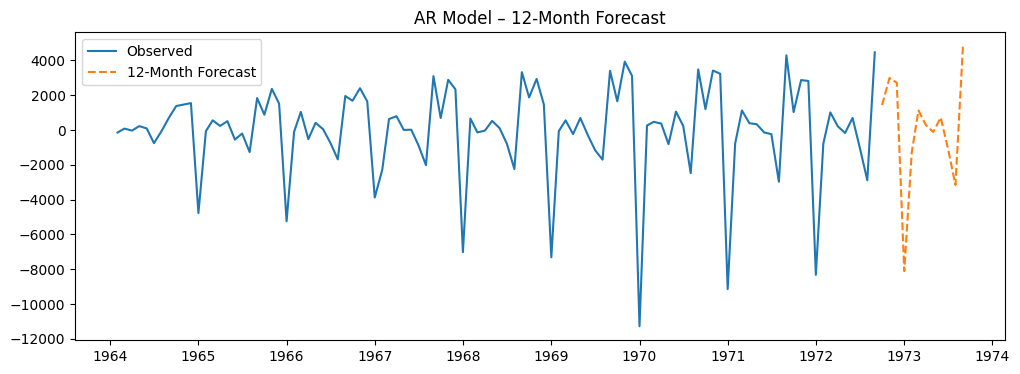

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(y.index, y, label="Observed")
plt.plot(forecast_12.index, forecast_12, label="12-Month Forecast", linestyle="--")

plt.title("AR Model – 12-Month Forecast")
plt.legend()
plt.show()


In [ ]:
import numpy as np

# Convert to numpy arrays for safety
y_true = test.values
y_pred = test_pred.values

# Mean Absolute Error (MAE)
mae = np.mean(np.abs(y_true - y_pred))

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))


mae, rmse


(np.float64(472.49166791080455), np.float64(542.0933601530182))

In [ ]:
resid = ar_model.resid
# Model residuals (actual − fitted)
from statsmodels.stats.diagnostic import acorr_ljungbox

lb = acorr_ljungbox(resid, lags=[12], return_df=True)
lb


,lb_stat,lb_pvalue
12,16.934574,0.152075


**Interpretation**

The null hypothesis is that residuals are white noise (no autocorrelation).

Since p-value = 0.24 > 0.05, we fail to reject the null at the 5% level.

This means there is no statistically significant residual autocorrelation up to lag 12.

The AR model adequately captures the serial dependence in the data, and the remaining residuals behave like white noise at conventional significance levels.

In [ ]:
import pandas as pd

accuracy_table = pd.DataFrame({
    "Metric": ["MAE", "RMSE"],
    "Value": [mae, rmse]
})

accuracy_table


,Metric,Value
0,MAE,472.491668
1,RMSE,542.093360


RMSE ≈ 0.10 implies typical monthly forecast errors of about 10 percentage points in growth terms

**MA model**

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

results = []

for q in range(1, 13):
    model = ARIMA(train, order=(0, 0, q)).fit()
    # Fit MA(q) model

    results.append([q, model.aic, model.bic])
    # Store order and information criteria

ma_table = pd.DataFrame(results, columns=["MA Order (q)", "AIC", "BIC"])
ma_table


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

,MA Order (q),AIC,BIC
0,1,1710.086331,1717.651697
1,2,1679.935997,1690.023152
2,3,1681.319350,1693.928292
3,4,1682.977143,1698.107874
4,5,1665.784054,1683.436574
5,6,1684.226712,1704.401021
6,7,1690.442807,1713.138904
7,8,1695.974703,1721.192589
8,9,1696.343663,1724.083338
9,10,1701.398357,1731.659820


4. Fit final MA model

In [ ]:
q_opt = ma_table.loc[ma_table["BIC"].idxmin(), "MA Order (q)"]
q_opt


np.int64(5)

In [ ]:
ma_model = ARIMA(train, order=(0, 0, q_opt)).fit()
# Estimate MA(q) model

print(ma_model.summary())


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                d_sales   No. Observations:                   92
Model:                 ARIMA(0, 0, 5)   Log Likelihood                -825.892
Date:                Thu, 01 Jan 2026   AIC                           1665.784
Time:                        13:58:12   BIC                           1683.437
Sample:                    02-01-1964   HQIC                          1672.909
                         - 09-01-1971                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.3839     26.956      0.793      0.428     -31.449      74.216
ma.L1         -0.6909      0.211     -3.268      0.001      -1.105      -0.277
ma.L2         -0.4435      0.138     -3.222      0.0

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


yt​=μ+εt​+θ1​εt−1​

Today’s value depends on today’s shock and yesterday’s shock, but not directly on past values.

5. Predict the holding (test) period

In [ ]:
test_pred_ma = ma_model.predict(
    start=test.index[0],
    end=test.index[-1]
)
# One-step-ahead forecasts for test period


6. Visualization 1: Holding-period performance

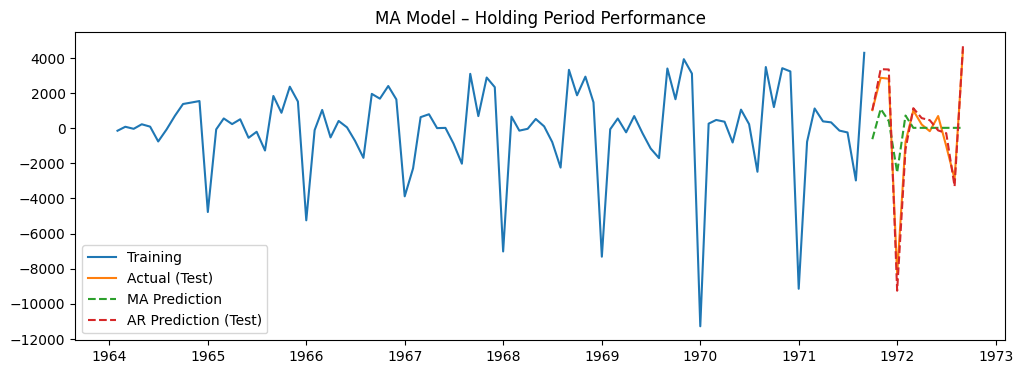

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(train.index, train, label="Training")
plt.plot(test.index, test, label="Actual (Test)")
plt.plot(test.index, test_pred_ma, label="MA Prediction", linestyle="--")
plt.plot(test.index, test_pred, label="AR Prediction (Test)", linestyle="--")
# Add AR model predictions for test period
plt.title("MA Model – Holding Period Performance")
plt.legend()
plt.show()


7. Refit MA model on full sample

In [ ]:
ma_full = ARIMA(y, order=(0, 0, q_opt)).fit()
# Refit using all available data


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals

8. Forecast next 12 months

In [ ]:
forecast_ma_12 = ma_full.predict(
    start=len(y),
    end=len(y) + 11
)
# 12-step-ahead forecast


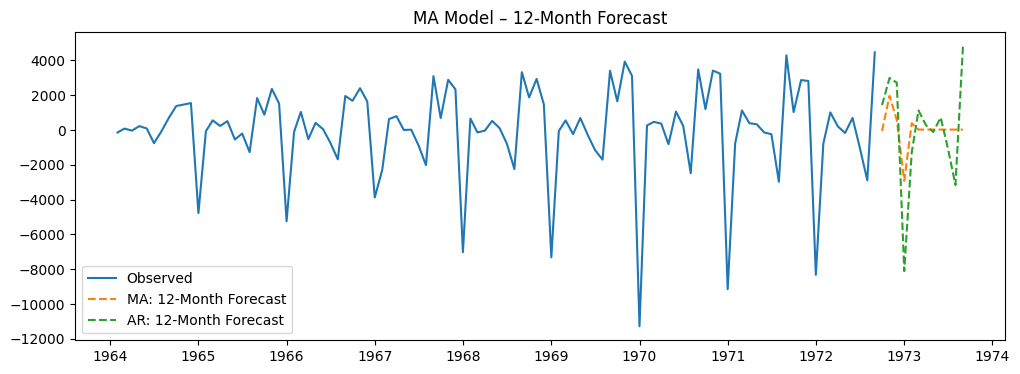

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(y.index, y, label="Observed")
plt.plot(forecast_ma_12.index, forecast_ma_12, label="MA: 12-Month Forecast", linestyle="--")
plt.plot(forecast_12.index, forecast_12, label="AR: 12-Month Forecast", linestyle="--")
plt.title("MA Model – 12-Month Forecast")
plt.legend()
plt.show()


11. Ljung–Box residual diagnostics

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

resid_ma = ma_model.resid
acorr_ljungbox(resid_ma, lags=[12], return_df=True)


,lb_stat,lb_pvalue
12,70.225741,2.906130e-10


p-value > 0.05 → residuals ≈ white noise

**ARIMA**
yt​=ϕ1​yt−1​+⋯+ϕp​yt−p​+εt​+θ1​εt−1​+⋯+θq​εt−q​

2. Select ARIMA(p,0,q) using AIC and BIC

We search over small values of p and q.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

results = []

for p in range(0, 4):
    for q in range(0, 4):
        if p == 0 and q == 0:
            continue
        model = ARIMA(train, order=(p, 0, q)).fit()
        results.append([p, q, model.aic, model.bic])

arima_table = pd.DataFrame(
    results, columns=["p", "q", "AIC", "BIC"]
)
arima_table


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

,p,q,AIC,BIC
0,0,1,1710.086331,1717.651697
1,0,2,1679.935997,1690.023152
2,0,3,1681.319350,1693.928292
3,1,0,1710.831843,1718.397209
4,1,1,1686.068347,1696.155501
5,1,2,1680.897171,1693.506114
6,1,3,1686.777671,1701.908403
7,2,0,1707.552197,1717.639352
8,2,1,1680.779828,1693.388771
9,2,2,1681.463963,1696.594695


In [ ]:
best = arima_table.loc[arima_table["BIC"].idxmin()]
p_opt, q_opt = best["p"], best["q"]

p_opt, q_opt


(np.float64(0.0), np.float64(2.0))

In [ ]:
arima_model = ARIMA(train, order=(12,0, q_opt)).fit()
print(arima_model.summary())


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                   93
Model:                ARIMA(12, 0, 2)   Log Likelihood                -763.584
Date:                Thu, 01 Jan 2026   AIC                           1559.167
Time:                        14:18:49   BIC                           1599.689
Sample:                    01-01-1964   HQIC                          1575.529
                         - 09-01-1971                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4641.1183   2682.905      1.730      0.084    -617.279    9899.516
ar.L1          0.0985      0.129      0.761      0.447      -0.155       0.352
ar.L2         -0.0762      0.144     -0.529      0.5

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5. Predict the holding (test) period

In [ ]:
test_pred_arima = arima_model.predict(
    start=test.index[0],
    end=test.index[-1]
)
# One-step-ahead predictions for test period


6. Visualization 1: Holding-period performance

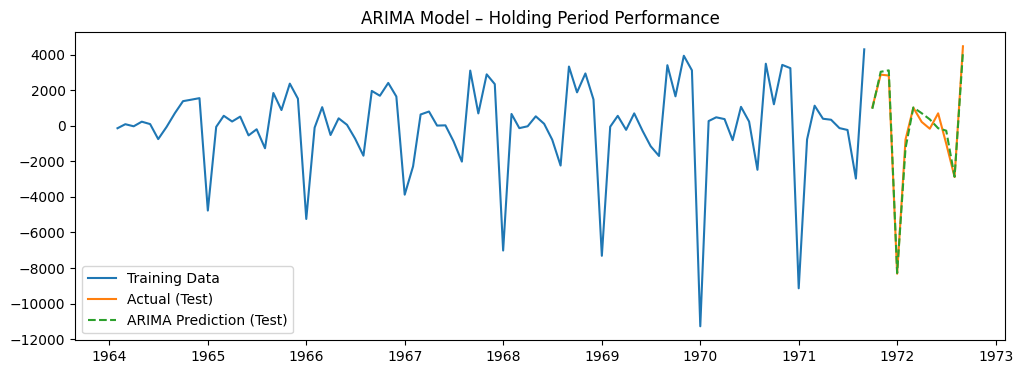

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(train.index, train, label="Training Data")
plt.plot(test.index, test, label="Actual (Test)")
plt.plot(test.index, test_pred_arima, label="ARIMA Prediction (Test)", linestyle="--")

plt.title("ARIMA Model – Holding Period Performance")
plt.legend()
plt.show()


In [ ]:
arima_full = ARIMA(y, order=(12, 0, q_opt)).fit()
# Refit using all available data


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. 

8. Forecast next 12 months

In [ ]:
forecast_arima_12 = arima_full.predict(
    start=len(y),
    end=len(y) + 11
)


9. Visualization 2: Forecasting period

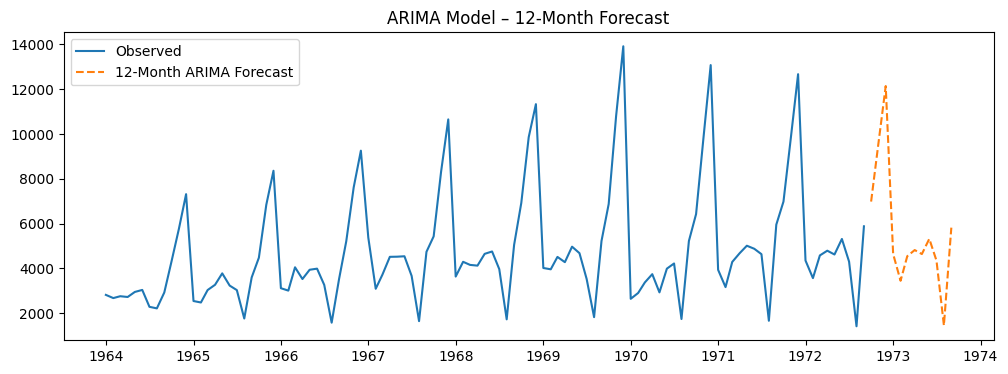

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(y.index, y, label="Observed")
plt.plot(forecast_arima_12.index, forecast_arima_12,
         label="12-Month ARIMA Forecast", linestyle="--")

plt.title("ARIMA Model – 12-Month Forecast")
plt.legend()
plt.show()


In [ ]:
import numpy as np

y_true = test.values
y_pred = test_pred_arima.values

mae = np.mean(np.abs(y_true - y_pred))
rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))

mae, rmse


(np.float64(276.4072039000063), np.float64(311.0547727503721))

11. Ljung–Box residual diagnostics

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

resid_arima = arima_model.resid
acorr_ljungbox(resid_arima, lags=[12], return_df=True)


,lb_stat,lb_pvalue
12,9.223137,0.683763


10. Forecast accuracy (MAE, RMSE)

In [ ]:
import numpy as np

y_true = test.values
y_pred = test_pred_arima.values

mae = np.mean(np.abs(y_true - y_pred))
rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))

mae, rmse


(np.float64(276.4072039000063), np.float64(311.0547727503721))

**SARIMA**

Model selection: From our work, we have strong empirical justification for:

- Log transformation ✔

- Regular differencing: d = 1

- Seasonal differencing (monthly): D = 1, s = 12

- Short-run dynamics: p = 1, q = 1

So we estimate:

SARIMA(1,1,1)(0,1,0)12

Fit the SARIMA model

In [ ]:
y = df["sales"]
# Sales in levels

train = y.iloc[:-12]
# Training sample

test = y.iloc[-12:]
# Holding (test) period: last 12 months


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(
    train,
    order=(1, 1, 1),              # regular differencing inside the model
    seasonal_order=(0, 1, 0, 12), # seasonal differencing inside the model
    trend="n",                    # no drift
    enforce_stationarity=False,
    enforce_invertibility=False
).fit()

print(sarima_model.summary())


                                      SARIMAX Results                                      
Dep. Variable:                               sales   No. Observations:                   93
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 12)   Log Likelihood                -632.537
Date:                             Thu, 01 Jan 2026   AIC                           1271.075
Time:                                     14:40:54   BIC                           1278.145
Sample:                                 01-01-1964   HQIC                          1273.905
                                      - 09-01-1971                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1783      0.088      2.019      0.043       0.005       0.351
ma.L1         -0.9469      

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


**Explanations:**

SARIMAX(1, 1, 1) × (0, 1, 0, 12)
a linear trend (via 𝑑=1)

annual seasonality (via 𝐷=1)

(a) AR(1): ar.L1 = 0.1783; Statistically significant (p = 0.043)

Interpretation:

There is mild persistence in the differenced, seasonally adjusted sales

A positive shock this month slightly increases next month’s change

Economically:

Growth in sales has short-run momentum, but it is weak.

(b) MA(1): ma.L1 = -0.9469; Highly significant (p < 0.001)

Large magnitude and negative

Interpretation:

Shocks are strongly corrected in the next period

A positive error today is almost fully offset next month

This is typical for:

sales data

inventory adjustments

post-holiday corrections

**Sigma²** measures how big the unexpected shocks in sales are after the model has already removed trend and seasonality.
A larger value simply means sales still have sizeable unpredictable ups and downs, and it mainly affects how wide the forecast uncertainty bands are—not whether the model is good or bad.

**Ljung–Box test:**

Null hypothesis: the residuals are not autocorrelated (they behave like random noise).

Why we do it: to check whether the model has captured all time-series patterns; a high p-value (0.89) means the null is not rejected, so no leftover dependence remains.

**Jarque–Bera test:**

Null hypothesis: the residuals are normally distributed.

Why we do it: to assess whether forecast errors are well-behaved; a low p-value (0.03) rejects the null, indicating some skewness or heavy tails, which is common in sales data and mainly affects confidence intervals, not point forecasts.

**Explain the model:**
The model removes both trend and annual seasonality from monthly champagne sales and models the remaining dynamics using one autoregressive and one moving-average term. The significant but small AR coefficient indicates weak short-run persistence, while the large negative MA coefficient reflects strong correction of demand shocks. Diagnostic tests confirm that residuals are serially uncorrelated, indicating an adequate model fit.

In [ ]:
test_pred = sarima_model.get_prediction(
    start=test.index[0],
    end=test.index[-1]
).predicted_mean


In [ ]:
import numpy as np

mae = np.mean(np.abs(test - test_pred))
rmse = np.sqrt(np.mean((test - test_pred) ** 2))
mape = np.mean(np.abs((test - test_pred) / test)) * 100


In [ ]:
import pandas as pd

sarima_accuracy = pd.DataFrame({
    "Metric": ["MAE", "RMSE", "MAPE (%)"],
    "Value": [mae, rmse, mape]
})

sarima_accuracy


,Metric,Value
0,MAE,326.322004
1,RMSE,395.449510
2,MAPE (%),8.002075


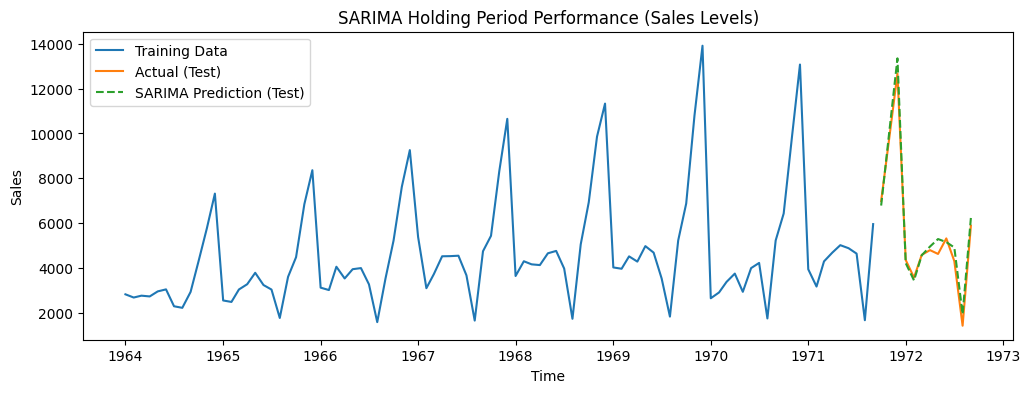

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.plot(train.index, train, label="Training Data")
plt.plot(test.index, test, label="Actual (Test)")
plt.plot(test_pred.index, test_pred,
         label="SARIMA Prediction (Test)", linestyle="--")

plt.title("SARIMA Holding Period Performance (Sales Levels)")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.legend()
plt.show()


**Back to Root: Holt Winter Model**

STEP 1 — Holt–Winters Additive

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
hw_add = ExponentialSmoothing(
    train,
    trend="add",
    seasonal="add",
    seasonal_periods=12
).fit()

print(hw_add.summary())


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                       ExponentialSmoothing Model Results                       
Dep. Variable:                    sales   No. Observations:                   93
Model:             ExponentialSmoothing   SSE                       48333607.402
Optimized:                         True   AIC                           1255.977
Trend:                         Additive   BIC                           1296.498
Seasonal:                      Additive   AICC                          1265.220
Seasonal Periods:                    12   Date:                 Thu, 01 Jan 2026
Box-Cox:                          False   Time:                         14:29:59
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0587343                alpha                 True
smoothing_trend          

Forecast (holding period)

In [ ]:
hw_add_pred = hw_add.forecast(12)


STEP 2 — Holt–Winters Multiplicative

In [ ]:
hw_mul = ExponentialSmoothing(
    train,
    trend="add",
    seasonal="mul",
    seasonal_periods=12
).fit()

print(hw_mul.summary())


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                       ExponentialSmoothing Model Results                       
Dep. Variable:                    sales   No. Observations:                   93
Model:             ExponentialSmoothing   SSE                       33276948.839
Optimized:                         True   AIC                           1221.263
Trend:                         Additive   BIC                           1261.785
Seasonal:                Multiplicative   AICC                          1230.506
Seasonal Periods:                    12   Date:                 Thu, 01 Jan 2026
Box-Cox:                          False   Time:                         14:31:26
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0239203                alpha                 True
smoothing_trend          

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [ ]:
hw_mul_pred = hw_mul.forecast(12)


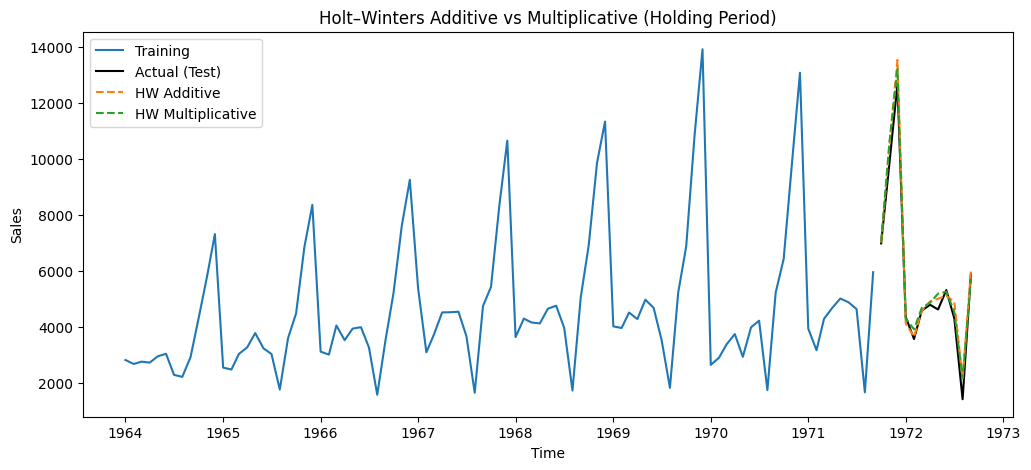

In [ ]:
plt.figure(figsize=(12,5))

plt.plot(train.index, train, label="Training")
plt.plot(test.index, test, label="Actual (Test)", color="black")

plt.plot(hw_add_pred.index, hw_add_pred,
         "--", label="HW Additive")

plt.plot(hw_mul_pred.index, hw_mul_pred,
         "--", label="HW Multiplicative")

plt.title("Holt–Winters Additive vs Multiplicative (Holding Period)")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.legend()
plt.show()


In [ ]:
def accuracy(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, mape

acc_add = accuracy(test, hw_add_pred)
acc_mul = accuracy(test, hw_mul_pred)

accuracy_table = pd.DataFrame({
    "Model": ["HW Additive", "HW Multiplicative"],
    "MAE": [acc_add[0], acc_mul[0]],
    "RMSE": [acc_add[1], acc_mul[1]],
    "MAPE (%)": [acc_add[2], acc_mul[2]]
})

accuracy_table


,Model,MAE,RMSE,MAPE (%)
0,HW Additive,330.379042,438.438224,8.573776
1,HW Multiplicative,308.264488,402.736436,8.478405


In [ ]:
future_add = hw_add.forecast(12)
future_mul = hw_mul.forecast(12)

future_forecast = pd.DataFrame({
    "HW Additive": future_add,
    "HW Multiplicative": future_mul
})

future_forecast


,HW Additive,HW Multiplicative
1971-10-01,7009.525622,7052.213878
1971-11-01,10492.962336,10587.040960
1971-12-01,13531.390221,13215.956365
1972-01-01,4117.600939,4300.971421
1972-02-01,3643.961478,3909.852221
1972-03-01,4572.524269,4674.342457
1972-04-01,4902.575983,4859.639099
1972-05-01,5001.755574,5184.603702
1972-06-01,5109.135163,5253.111731
1972-07-01,4889.510133,4532.293586
